In [1]:
import pickle
from lightgbm import LGBMRegressor
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

xy_data_dir = '/Users/mmw/Documents/GitHub/ml_val/data_all/xy_data'

with open(xy_data_dir + '/x_q_1_0_tr.pkl', 'rb') as handle:
    x_tr = pickle.load(handle).iloc[:,5:]
    x_tr.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    x_tr = x_tr.fillna(0).astype('float32')
    
with open(xy_data_dir + '/y_q_1_0_tr.pkl', 'rb') as handle:
    y_tr = pickle.load(handle).iloc[:,5:]
    y_tr.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    y_tr = y_tr.fillna(0).astype('float32')
    
with open(xy_data_dir + '/x_q_1_0_ts.pkl', 'rb') as handle:
    x_ts = pickle.load(handle).iloc[:,5:]
    x_ts.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    x_ts = x_ts.fillna(0).astype('float32')
    
with open(xy_data_dir + '/y_q_1_0_ts.pkl', 'rb') as handle:
    y_ts = pickle.load(handle).iloc[:,5:]
    y_ts.replace([np.inf, -np.inf, 'inf', '-inf'], np.NaN, inplace=True)
    y_ts = y_ts.fillna(0).astype('float32')

In [2]:
print(x_tr.shape, x_ts.shape)

(280270, 319) (161072, 319)


In [3]:
for index, item in enumerate(x_tr.columns):
    print(index, item)

0 absacc
1 acc
2 agr
3 bm_ia
4 cashdebt
5 cashpr
6 cfp
7 cfp_ia
8 chatoia
9 chcsho
10 chempia
11 chinv
12 chpmia
13 convind
14 currat
15 currat
16 depr
17 divi
18 divo
19 dy
20 egr
21 ep
22 gma
23 grcapx
24 grltnoa
25 herf
26 hire
27 invest
28 lev
29 lgr
30 mve_ia
31 operprof
32 orgcap
33 pchcapx_ia
34 pchcurrat
35 pchdepr
36 pchgm_pchsale
37 pchquick
38 pchsale_pchinvt
39 pchsale_pchrect
40 pchsale_pchxsga
41 pchsaleinv
42 pctacc
43 ps
44 quick
45 rd
46 rd_mve
47 rd_sale
48 realestate
49 roic
50 salecash
51 saleinv
52 salerec
53 secured
54 securedind
55 sgr
56 sin
57 sp
58 tang
59 tb
60 aeavol
61 cash
62 chtx
63 cinvest
64 ear
65 roaq
66 roavol
67 roeq
68 rsup
69 stdacc
70 stdcf
71 chmom
72 dolvol
73 mom12m
74 mom1m
75 mom36m
76 mom6m
77 mvel1
78 turn
79 revt
80 ebit
81 ebitda
82 re
83 epspi
84 gma
85 operprof
86 quick
87 currat
88 cashrrat
89 cftrr
90 dpr
91 pe
92 pb
93 roe
94 roa
95 roic
96 cod
97 capint
98 lev
99 revt_aoa
100 ebit_aoa
101 ebitda_aoa
102 re_aoa
103 epspi_aoa
104 gma

In [4]:
list(y_tr.columns)

['revtq',
 'req',
 'epspiq',
 'quickq',
 'curratq',
 'cashrratq',
 'peq',
 'roeq',
 'roaq',
 'revtq_qoq',
 'req_qoq',
 'epspiq_qoq',
 'quickq_qoq',
 'curratq_qoq',
 'cashrratq_qoq',
 'peq_qoq',
 'roeq_qoq',
 'roaq_qoq',
 'revtq_aoa',
 'req_aoa',
 'epspiq_aoa',
 'quickq_aoa',
 'curratq_aoa',
 'cashrratq_aoa',
 'peq_aoa',
 'roeq_aoa',
 'roaq_aoa',
 'revtq_5o5',
 'req_5o5',
 'epspiq_5o5',
 'quickq_5o5',
 'curratq_5o5',
 'cashrratq_5o5',
 'peq_5o5',
 'roeq_5o5',
 'roaq_5o5']

In [5]:
oosr2 = {}

def single_feature_oosr2(item, x_tr=x_tr, y_tr=y_tr, x_ts=x_ts, y_ts=y_ts, 
                         param_test = {'max_depth': [1]}):
    try:
        _ = x_tr[item].values.shape[1]
        x_tr_single = x_tr[item].values[:, 0].reshape(-1, 1)
        y_tr_single = y_tr[item].values
        x_ts_single = x_ts[item].values[:, 0].reshape(-1, 1)
        y_ts_single = y_ts[item].values
    except IndexError:
        x_tr_single = x_tr[item].values.reshape(-1, 1)
        y_tr_single = y_tr[item].values
        x_ts_single = x_ts[item].values.reshape(-1, 1)
        y_ts_single = y_ts[item].values
    
    mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
    clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=5)
    clf.fit(x_tr_single, y_tr_single)
    predictions = clf.predict(x_ts_single)

    return sklearn.metrics.r2_score(y_ts_single, predictions)

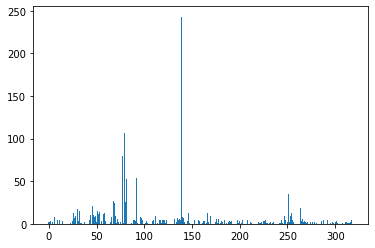

revtq 0.7198555224514682 0.2565681358425073 ['revtq', 'revt', 'mvel1', 'pb', 'ebitda']
{'max_depth': 6, 'n_estimators': 500, 'num_leaves': 4}


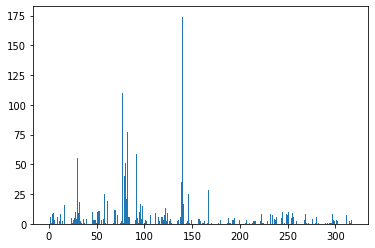

req 0.5362185020329149 0.5423416316358873 ['req', 'mvel1', 're', 'pb', 'mve_ia']
{'max_depth': 6, 'n_estimators': 500, 'num_leaves': 4}


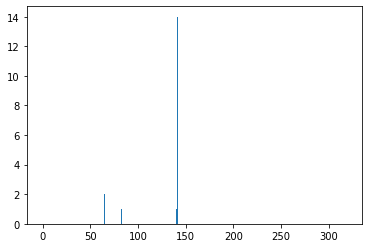

epspiq 0.008018367924330194 -0.29667081938844864 ['epspiq', 'roaq', 'sp', 'epspi', 'req']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


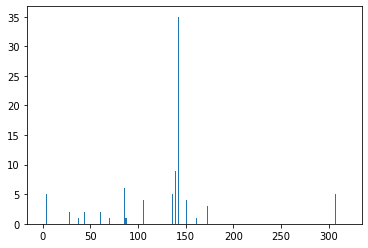

quickq 0.27704924245560114 0.0216697725595869 ['quickq', 'revtq', 'curratq', 'quick', 'currat_med_5o5']
{'max_depth': 1, 'n_estimators': 100, 'num_leaves': 2}


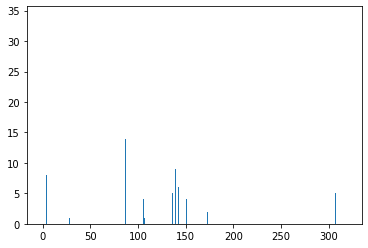

curratq 0.28998088969224833 0.021634991709324914 ['curratq', 'currat', 'revtq', 'cashdebt', 'quickq']
{'max_depth': 1, 'n_estimators': 100, 'num_leaves': 2}


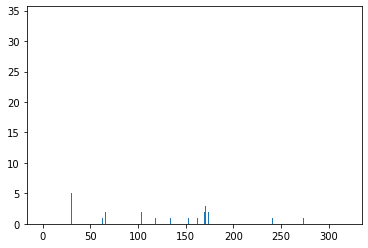

cashrratq 0.05774158873734436 -0.24296237754857322 ['cashrratq', 'mve_ia', 'cashrratq_5o5', 'roavol', 'gma_aoa']
{'max_depth': 6, 'n_estimators': 20, 'num_leaves': 4}


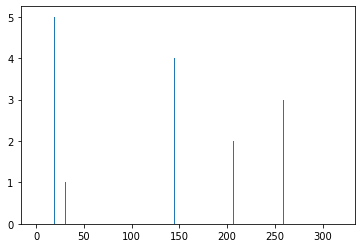

peq 1.2526192036954598e-06 -0.879275075301257 ['dy', 'peq', 'currat_med', 'dolvol', 'epspi_med_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


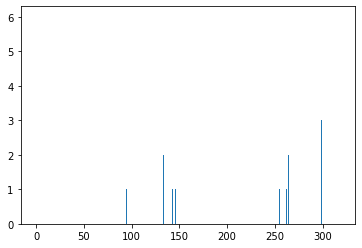

roeq -0.00026614082024156716 -11.142052845002118 ['roe_med_5o5', 'revt_med_5o5', 'rsup', 'pb_med', 'roe_5o5']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


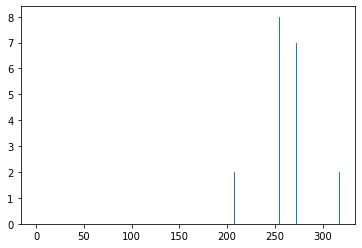

roaq -0.0008120296846609865 -69.9104563867934 ['epspi_med', 'ebitda_sum_aoa', 'lev_med_5o5', 'gma_med_aoa', 'ebitda_sum']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


In [6]:
# level prediction

for item in y_tr.columns:
    if '_5o5' in item or '_qoq' in item or '_aoa' in item:
        continue    
    param_test = {'max_depth': [1, 6], 'num_leaves': [2, 4], 'n_estimators': [20, 100, 500]}
    mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
    clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=5)
    clf.fit(x_tr.values, y_tr[item].values)
    predictions = clf.predict(x_ts.values)
    y_true = y_ts[item].values 
    plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
    plt.show()
    max_fea = []
    max_5 = clf.best_estimator_.feature_importances_.argsort()[-5:][::-1]
    for index in max_5:
        max_fea.append(x_tr.columns[index])
    oosr2[item] = sklearn.metrics.r2_score(y_true, predictions)
    try:
        sig_feature_oosr2 = single_feature_oosr2(item, param_test=param_test)
        enhancement = (oosr2[item] - sig_feature_oosr2)/sig_feature_oosr2
        print(item, oosr2[item], enhancement, max_fea)
        print(clf.best_params_)
    except KeyError:
        print(item, oosr2[item], max_fea)
        print(clf.best_params_)

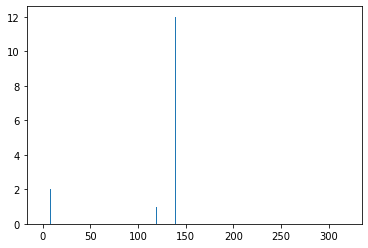

revtq_aoa 0.0005410013432056715 3.8744274561836796 ['revtq', 'revtq_5o5', 'sp', 'chatoia', 'revt_5o5']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


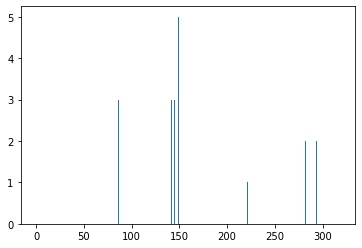

req_aoa -0.0003629194589485074 1.9148840662716147 ['req_qoq', 'peq', 'quickq', 'quick', 'quick_med_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


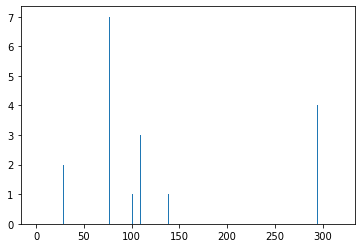

epspiq_aoa -3.505589640973028e-05 -2.103513888179584 ['mvel1', 'revt_sum_5o5', 'cftrr_aoa', 'lgr', 'curratq_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


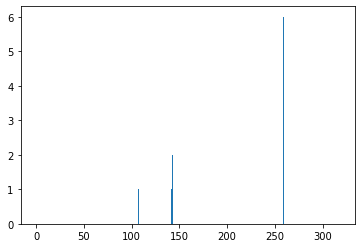

quickq_aoa -12.118203124439782 47.15019306407873 ['currat_med', 'herf', 'rd_mve', 'curratq', 'currat_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


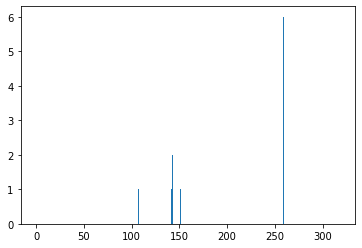

curratq_aoa -13.024247874126548 39.63877934886533 ['currat_med', 'herf', 'rd_mve', 'curratq', 'currat_aoa']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


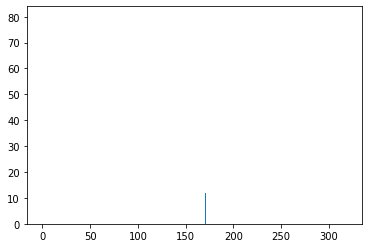

cashrratq_aoa 0.008157930005122549 7.198472036245733 ['cashrratq', 'cashrratq_5o5', 'cashrratq_aoa', 'lev_med_5o5', 'quick_aoa']
{'max_depth': 1, 'n_estimators': 100, 'num_leaves': 2}


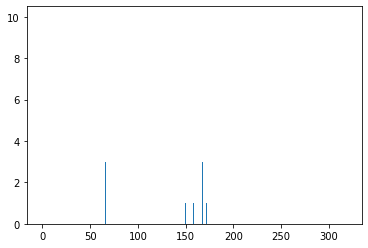

peq_aoa -0.02324657448651468 653.4842790153924 ['epspiq', 'roavol', 'epspiq_5o5', 'req_aoa', 'req']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


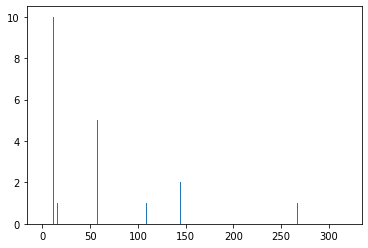

roeq_aoa -6.3625303039493986e-06 0.027545153705499748 ['chpmia', 'tang', 'peq', 'depr', 'roic_med']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


KeyboardInterrupt: 

In [7]:
# year on year growth prediction

for item in y_tr.columns:
    if '_aoa' not in item:
        continue    
#     param_test = {'max_depth': [1, 6], 'num_leaves': [2, 4], 'n_estimators': [20, 100, 500]}
    param_test = {'max_depth': [1], 'num_leaves': [2], 'n_estimators': [20, 100, 500]}
    mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
    clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=5)
    clf.fit(x_tr.values, y_tr[item].values)
    predictions = clf.predict(x_ts.values)
    y_true = y_ts[item].values 
    plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
    plt.show()
    max_fea = []
    max_5 = clf.best_estimator_.feature_importances_.argsort()[-5:][::-1]
    for index in max_5:
        max_fea.append(x_tr.columns[index])
    oosr2[item] = sklearn.metrics.r2_score(y_true, predictions)
    try:
        sig_feature_oosr2 = single_feature_oosr2(item, param_test=param_test)
        enhancement = (oosr2[item] - sig_feature_oosr2)/sig_feature_oosr2
        print(item, oosr2[item], enhancement, max_fea)
        print(clf.best_params_)
    except KeyError:
        print(item, oosr2[item], max_fea)
        print(clf.best_params_)

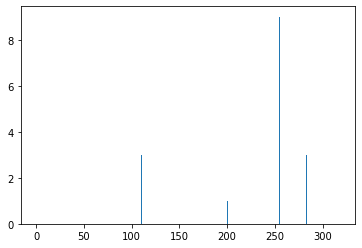

roaq_aoa -0.18052241676750835 782.4230218196926 ['epspi_med', 'dpr_aoa', 'currat_med_aoa', 'ebitda_sum', 'roic_med_5o5']
{'max_depth': 1, 'n_estimators': 20, 'num_leaves': 2}


In [8]:
# year on year growth prediction

for item in y_tr.columns:
    if 'roaq_aoa' not in item:
        continue    
#     param_test = {'max_depth': [1, 6], 'num_leaves': [2, 4], 'n_estimators': [20, 100, 500]}
    param_test = {'max_depth': [1], 'num_leaves': [2], 'n_estimators': [20, 100, 500]}
    mod = LGBMRegressor(objective='regression_l2', zero_as_missing=True)
    clf = sklearn.model_selection.GridSearchCV(mod , param_grid = param_test, scoring='r2', cv=5)
    clf.fit(x_tr.values, y_tr[item].values)
    predictions = clf.predict(x_ts.values)
    y_true = y_ts[item].values 
    plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
    plt.show()
    max_fea = []
    max_5 = clf.best_estimator_.feature_importances_.argsort()[-5:][::-1]
    for index in max_5:
        max_fea.append(x_tr.columns[index])
    oosr2[item] = sklearn.metrics.r2_score(y_true, predictions)
    try:
        sig_feature_oosr2 = single_feature_oosr2(item, param_test=param_test)
        enhancement = (oosr2[item] - sig_feature_oosr2)/sig_feature_oosr2
        print(item, oosr2[item], enhancement, max_fea)
        print(clf.best_params_)
    except KeyError:
        print(item, oosr2[item], max_fea)
        print(clf.best_params_)